What are the zero-exposure tweets like?

In [1]:
from imports import * 

In [2]:
campaigns = preprocessing.load_campaign()
with open(os.path.join(TWITTER_DATA_DIR, 'exposure_results.pkl'), 'rb') as f:
    exposures = pickle.load(f)

In [3]:
with open(os.path.join(TWITTER_DATA_DIR, 'n_newly_exposed_by_user.pkl'), 'rb') as f:
    new_exposures = pickle.load(f)

new_exposures_df = pd.DataFrame(pd.DataFrame(new_exposures).T.stack())
new_exposures_df.index = new_exposures_df.index.set_names(['hashtag', 'username'])
new_exposures_df.columns = ['newly_exposed_users']
new_exposures_df.head()

newly_exposed_users
hashtag           username                            
jharkhandwithmodi manojgoelbjp                 13636.0
                  moonmuks                         0.0
                  sanjay_mishra91               1828.0
                  ch_rahul29                     932.0
                  shaileshmishra                2043.0

In [4]:
dfs = []
for hashtag, tweets in tqdm(campaigns.items()):
    if hashtag not in preprocessing.bandwagon_hashtags and hashtag not in preprocessing.never_trended:
        _, df = trending.build_df(hashtag, tweets, exposures, 
                                  raw_df_too=True, include_missing=False, 
                                  cutoff_choice='earliest')
        dfs.append(df.merge(new_exposures_df.reset_index(), on=['username', 'hashtag']))
panel_df = pd.concat(dfs)
panel_df.head()

,username,id,retweet_from,template,retweet_id,text,date,retweets,favorites,adj_date,type,follower_data,template_exposure,normal_exposure,total_exposure,time,trending_start,inferred_trending_start,hashtag,newly_exposed_users
0,bjp4latehar,1172033856607682560,,,,आधारभूत संरचना हो या शिक्षा या फिर स्वच्छता या...,2019-09-12 06:27:01,0,0,2019-09-12 11:57:01,regular,True,151,64,215,2019-09-12 11:57:01,2019-02-17 15:30:00,2019-02-17 14:30:00,jharkhandwithmodi,0.0
1,bjp4latehar,1172027968400445440,,,,झारखण्ड सरकार किसी भी आपात स्थिति में पीड़ित क...,2019-09-12 06:03:37,0,0,2019-09-12 11:33:37,regular,True,151,64,215,2019-09-12 11:33:37,2019-02-17 15:30:00,2019-02-17 14:30:00,jharkhandwithmodi,0.0
2,bjp4latehar,1172028765326569472,,,,अब राजपत्रित नौकरियों को छोड़कर सभी सरकारी नौक...,2019-09-12 06:06:47,0,0,2019-09-12 11:36:47,regular,True,151,64,215,2019-09-12 11:36:47,2019-02-17 15:30:00,2019-02-17 14:30:00,jharkhandwithmodi,0.0
3,bjp4latehar,1172029990159781888,,,,झारखण्ड गठन के बाद पहली बार रघुवर सरकार ने राज...,2019-09-12 06:11:39,0,0,2019-09-12 11:41:39,regular,True,151,64,215,2019-09-12 11:41:39,2019-02-17 15:30:00,2019-02-17 14:30:00,jharkhandwithmodi,0.0
4,bjp4latehar,1172086387274743809,bjp4jharkhand,,1172070404157870080,rt @bjp4jharkhand: आज का दिन झारखंड के लिए ऐति...,2019-09-12 09:55:45,31,0,2019-09-12 15:25:45,regular_retweet,True,151,64,215,2019-09-12 15:25:45,2019-02-17 15:30:00,2019-02-17 14:30:00,jharkhandwithmodi,0.0


## Network Level Info

In [8]:
network_user_df = pd.read_pickle(os.path.join(TWITTER_DATA_DIR, 'user_network_stats.pkl'))
network_user_df

,pr,cc,outdeg,indeg
0001atulrai,0.000003,0.995769,42.0,20.0
0001sudarshan,0.000003,0.279654,86.0,48.0
0006subhash,0.000002,0.339958,76.0,6.0
000fdc0fb7974a7,0.000002,0.549075,29.0,9.0
000pal,0.000002,0.250375,107.0,3.0
...,...,...,...,...
___subodh,0.000002,0.338983,457.0,13.0
____daddysgirl,0.000002,0.000000,0.0,0.0
____realpatel__,0.000002,0.275299,196.0,41.0
_____anusha,0.000003,0.396820,177.0,20.0


## Analyzing Users
For each user, how many followers do they have? 

In [9]:
def describe_users(big_df):
    res_dict = {}
    stats = ['# Tweets', '# Followers', '# Campaigns', 'Avg. Retweets', 'Avg. Favorites', 
             'PageRank', 'Clustering Coef.', 'Out-Degree', 'In-Degree', 'Avg. Newly Exposed']
    def get_user_stats(df, mean=False):
        temp = [len(df)]
        username = df.username.iloc[0]
        path = os.path.join(FOLLOWER_DATA_DIR, username + '.gz')
        f = gzip.open(path, 'rb')
        try:
            followers = [x.split('\t')[1] for x in f.read().decode().strip().split('\n')]
            temp.append(len(followers))
        except Exception as e:
            print(e, 'issue with ', username)
            temp.append(-1)
        temp.append(len(df.hashtag.unique()))
        if mean:
            temp.append(df.retweets.mean())
            temp.append(df.favorites.mean())    
        else:
            temp.append(df.retweets.median())
            temp.append(df.favorites.median())    
        temp.append(df.pr.iloc[0])
        temp.append(df.cc.iloc[0])
        temp.append(df.outdeg.iloc[0])
        temp.append(df.indeg.iloc[0])
        temp.append(df.newly_exposed_users.iloc[0])
        res_dict[username] = temp

    big_df.groupby('username').apply(get_user_stats)
    t = pd.DataFrame(res_dict).T
    t.columns = stats
    return t 

In [10]:
big_panel = []
meta_df = []
def helper(df, desc):
    t = describe_users(df)
    t['Group'] = desc 
    big_panel.append(t)
    meta_df.append(
        pd.concat({desc: t.describe()}, names=['User Group']))    

In [11]:
zero_exposure_tweeters = panel_df.query('total_exposure == 0').query('type == "regular"') \
.query('adj_date > inferred_trending_start').join(network_user_df, on='username')

helper(zero_exposure_tweeters, 'Zero-Exposure, Post-Hashtag')

list index out of range issue with  movies_it


In [12]:
zero_exposure_tweeters_pre_trend = panel_df.query('total_exposure == 0').query('type == "regular"') \
    .query('adj_date < inferred_trending_start').join(network_user_df, on='username')
helper(zero_exposure_tweeters_pre_trend,  'Zero-Exposure, Pre-Hashtag')

In [13]:
others = panel_df.query('total_exposure != 0').query('type == "regular"').join(network_user_df, on='username')
helper(others, 'Exposed, Non-Template')

list index out of range issue with  faraktesuresh
list index out of range issue with  kolinilangi
list index out of range issue with  movies_it
list index out of range issue with  shyamsu08245833


In [14]:
templates = panel_df.query('type == "template"').join(network_user_df, on='username')
helper(templates, 'Template')

list index out of range issue with  faraktesuresh
list index out of range issue with  kajal_barge
list index out of range issue with  kolinilangi
list index out of range issue with  shyamsu08245833


In [15]:
res = pd.concat(meta_df)
res.index = res.index.set_names(['User Type', 'Statistic'])
res

# Tweets   # Followers  \
User Type                   Statistic                               
Zero-Exposure, Post-Hashtag count       2093.000000  2.093000e+03   
                            mean           1.568562  2.470716e+04   
                            std            1.391969  3.458384e+05   
                            min            1.000000 -1.000000e+00   
                            25%            1.000000  6.200000e+01   
                            50%            1.000000  2.180000e+02   
                            75%            2.000000  1.089000e+03   
                            max           16.000000  1.310638e+07   
Zero-Exposure, Pre-Hashtag  count        743.000000  7.430000e+02   
                            mean           1.049798  6.362263e+04   
                            std            0.277546  7.365588e+05   
                            min            1.000000  1.000000e+00   
                            25%            1.000000  1.005000e+02   
                            50%            1.000000  3.820000e+02   
                            75%            1.000000  1.538000e+03   
                            max            5.000000  1.310638e+07   
Exposed, Non-Template       count      16328.000000  1.632800e+04   
                            mean          10.967234  2.020173e+04   
                            std           47.054696  2.522333e+05   
                            min            1.000000 -1.000000e+00   
                            25%            1.000000  1.367500e+02   
                            50%            3.000000  4.960000e+02   
                            75%            8.000000  2.095500e+03   
                            max         2230.000000  1.310638e+07   
Template                    count       3234.000000  3.234000e+03   
                            mean          14.452381  1.164627e+04   
                            std           29.805458  1.745905e+05   
                            min            1.000000 -1.000000e+00   
                            25%            1.000000  7.725000e+01   
                            50%            4.000000  3.800000e+02   
                            75%           13.000000  1.745750e+03   
                            max          385.000000  8.654833e+06   

                                        # Campaigns  Avg. Retweets  \
User Type                   Statistic                                
Zero-Exposure, Post-Hashtag count       2093.000000    2083.000000   
                            mean           1.568562       7.798848   
                            std            1.391969      83.119251   
                            min            1.000000       0.000000   
                            25%            1.000000       0.000000   
                            50%            1.000000       0.000000   
                            75%            2.000000       1.000000   
                            max           16.000000    2613.000000   
Zero-Exposure, Pre-Hashtag  count        743.000000     741.000000   
                            mean           1.049798      18.117409   
                            std            0.277546     130.877701   
                            min            1.000000       0.000000   
                            25%            1.000000       0.000000   
                            50%            1.000000       0.000000   
                            75%            1.000000       2.000000   
                            max            5.000000    2036.000000   
Exposed, Non-Template       count      16328.000000   16274.000000   
                            mean           2.288094       6.907306   
                            std            2.310269      94.964928   
                            min            1.000000       0.000000   
                            25%            1.000000       0.000000   
                            50%            1.000000       0.000000   
                

In [16]:
temp = pd.concat(big_panel)

In [17]:
user_df = preprocessing.load_user_data()

# Examining Tweets
Categories:
- completely disjoint
- from people whose outdegree is 0

What do I want to know?
- Spam
- What are the tweets

<AxesSubplot:ylabel='Frequency'>

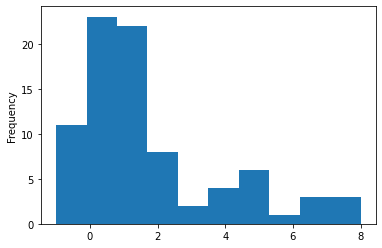

In [80]:
t.trending_hashtags.plot(kind='hist')

In [94]:
def annotate(df, summarize=True):
    df['hashtags_used'] = df.text.apply(lambda x: x.count('#'))
    df['users_tagged'] = df.text.apply(lambda x: x.count('@'))
    df['includes_link'] = df.text.apply(lambda x: int('http' in x))
    # df['trending_hashtags'] = df.apply(compare_to_trends, axis=1)
    return df

In [82]:
import re

def get_trends_on_date(date):
    date_str = str(date)
    path = os.path.join(TRENDS_DIR, date_str[:10] + '.csv')
    if os.path.exists(path):
        temp = pd.read_csv(path, header=None,
                    names=['hashtag', 'place',
                           'level', 'day',
                           'time', 'volume', 'nan'])

        time = date_str[11:13] + ':00'
        return temp.query(f'time == "{time}"').hashtag.unique()
    else:
        return None 

def compare_to_trends(x):
    # take a tweet, extract hashtags, return matches
    text = x.text

    regex = "#(\w+)"
    hashtag_list = re.findall(regex, text) 
    hashtag_list = [t.lower().replace('#', '') for t in hashtag_list]
    t_list = get_trends_on_date(x.date)
    if t_list is None:
        return -1 
    trending_hashtags = [t.lower().replace('#', '') for t in t_list]
    
    return len(set(hashtag_list).intersection(set(trending_hashtags)))

In [92]:
zero_exposure_tweeters

,username,id,retweet_from,template,retweet_id,text,date,retweets,favorites,adj_date,...,hashtag,newly_exposed_users,pr,cc,outdeg,indeg,hashtags_used,users_tagged,includes_link,trending_hashtags
6308,bjp4india,1097072525337518081,,,,pm modi lays foundation stone &amp; inaugurates development projects at hazaribagh. #jharkhandwithmodi https://t.co/lotbcmvoog,2019-02-17 09:57:27,1165,1406,2019-02-17 15:27:27,...,jharkhandwithmodi,11346536.0,0.002004,0.007457,3.0,49100.0,1,0,1,0
8326,rajkamalchy,1172126423215046657,,,,झारखंड की @dasraghubar सरकार ने बहुत शानदार विधानसभा भवन बनवाए हैं. #jharkhandwithmodi https://t.co/5obsqugcnc,2019-09-12 12:34:51,2,4,2019-09-12 18:04:51,...,jharkhandwithmodi,78.0,0.000003,0.302772,28.0,73.0,1,1,1,-1
8699,trueself1950,1172034400550150146,,,,#haryana #jharkhand #jharkhandwithmodi #maharashtra #delhi #himachal https://t.co/i8amoztldu,2019-09-12 06:29:11,1,0,2019-09-12 11:59:11,...,jharkhandwithmodi,0.0,0.000002,0.326476,126.0,0.0,6,0,1,-1
8949,nikhilpec,1174702877291368454,,,,grandma sells new born baby to save life of daughter in law. father of baby sick. mother of baby died at gumla #jharkhand #jharkhandwithmodi #poverty,2019-09-19 15:12:45,0,0,2019-09-19 20:42:45,...,jharkhandwithmodi,54.0,0.000002,0.076023,13.0,6.0,3,0,0,-1
9295,mejayvardhan,1172154370768560131,,,,"@narendramodi 19 साल का इंतजार खत्म... finally, jharkhand has it's brand new vidhan sabha. prime minister shri @narendramodi has inaugurated the new jharkhand vidhan sabha earlier today. this is remarkable @dasraghubar ji. #jharkhandwithmodi https://t.co/bjqodknlo5",2019-09-12 14:25:54,0,15,2019-09-12 19:55:54,...,jharkhandwithmodi,54.0,0.000002,0.196667,3.0,22.0,1,3,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3785,rashamijigarad2,1050554142241038336,,,,#navratri अवश्य जानिए कि दुर्गा जी सब बातों को छोड़कर ब्रम्ह की शरण में जाने को क्यो कह रही हैं? अवश्य देखिये👉साधनाtv7.30pm @ddnewslive @timesofindia #gappupappu https://t.co/ds7idxkotr,2018-10-12 01:10:00,0,0,2018-10-12 06:40:00,...,gappupappu,2.0,0.000002,0.666667,6.0,1.0,2,2,1,2
4134,shastriji1972,1051123608464973824,,,,"रा.फे.ल. (राफेल) का अर्थ है, ""राहुल गांधी एक फेल लड़का है"". शायद #rahulgandhi औऱ #congress इसीलिए #rafale के गीत गा रही है। @narendramodi @rahulgandhi @incindia @bjp4india #gappupappu #greatdebateshow #rafaledeal #rafalescam #rahulgandhi https://t.co/kprepupxxs",2018-10-13 14:52:51,0,1,2018-10-13 20:22:51,...,gappupappu,12.0,0.000002,0.200000,4.0,1.0,8,4,1,0
4154,sourabhtamesh,1050693726907977729,,,,@rahulgandhi #gappupappu https://t.co/ximdwjkjzo,2018-10-12 10:24:40,0,0,2018-10-12 15:54:40,...,gappupappu,14.0,0.000002,0.248056,68.0,6.0,1,1,1,0
4390,satya_bol,1050438369560281088,,,,#rafalescamgrandexpose or #gappupappu ? https:// twitter.com/daarubaazmehta /status/1050437410511712257?s=20 …,2018-10-11 17:29:00,0,0,2018-10-11 22:59:00,...,gappupappu,93.0,0.000003,0.356440,22.0,72.0,2,0,1,1


In [96]:
annotate(templates).describe()

,newly_exposed_users,pr,cc,outdeg,indeg,hashtags_used,users_tagged,includes_link
count,4.673900e+04,46739.000000,46739.000000,46739.000000,46739.000000,46739.000000,46739.000000,46739.000000
mean,2.982614e+03,0.000007,0.395876,460.656047,380.231520,1.312630,0.965874,0.175442
std,3.479939e+04,0.000022,0.201782,709.934242,991.219524,1.022468,1.766086,0.380349
min,0.000000e+00,0.000002,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.200000e+01,0.000002,0.274496,72.000000,17.000000,1.000000,0.000000,0.000000
50%,9.000000e+01,0.000003,0.366811,224.000000,72.000000,1.000000,0.000000,0.000000
75%,5.330000e+02,0.000005,0.489177,555.500000,296.000000,1.000000,1.000000,0.000000
max,2.199763e+06,0.001156,2.000000,15352.000000,31286.000000,14.000000,50.000000,1.000000


In [95]:
annotate(others).describe()

,newly_exposed_users,pr,cc,outdeg,indeg,hashtags_used,users_tagged,includes_link
count,1.790730e+05,179073.000000,179073.000000,179073.000000,179073.000000,179073.000000,179073.000000,179073.000000
mean,2.646261e+04,0.000017,0.375919,436.503046,641.240946,2.370860,1.084815,0.570371
std,4.217900e+05,0.000108,0.208107,693.183069,2991.756655,2.587715,2.574547,0.495025
min,0.000000e+00,0.000002,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,4.000000e+00,0.000002,0.250000,40.000000,7.000000,1.000000,0.000000,0.000000
50%,5.700000e+01,0.000003,0.345602,187.000000,54.000000,1.000000,0.000000,1.000000
75%,3.860000e+02,0.000005,0.472222,521.000000,281.000000,3.000000,1.000000,1.000000
max,1.160521e+07,0.002004,3.666667,15352.000000,49100.000000,30.000000,50.000000,1.000000


In [88]:
t = annotate(zero_exposure_tweeters)
t.describe()

,newly_exposed_users,pr,cc,outdeg,indeg,hashtags_used,users_tagged,includes_link,trending_hashtags
count,3.283000e+03,3283.000000,3283.000000,3283.000000,3283.000000,3283.000000,3283.000000,3283.000000,3283.000000
mean,4.892775e+04,0.000018,0.320031,60.431922,522.224185,3.245203,0.869327,0.495888,1.032897
std,6.359319e+05,0.000144,0.242430,121.083275,3646.641383,3.508309,2.431696,0.500059,1.572777
min,0.000000e+00,0.000002,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.000000
25%,1.800000e+01,0.000002,0.159671,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000
50%,7.700000e+01,0.000002,0.292883,18.000000,16.000000,2.000000,0.000000,0.000000,1.000000
75%,3.725000e+02,0.000003,0.438971,65.000000,85.000000,4.000000,1.000000,1.000000,1.000000
max,1.159423e+07,0.002004,2.000000,1563.000000,49100.000000,27.000000,50.000000,1.000000,10.000000


In [86]:
t = annotate(zero_exposure_tweeters.query('outdeg == 0 and indeg == 0'))
t.describe()

,newly_exposed_users,pr,cc,outdeg,indeg,hashtags_used,users_tagged,includes_link,trending_hashtags
count,83.000000,8.300000e+01,83.0,83.0,83.0,83.000000,83.000000,83.000000,83.000000
mean,10.265060,1.893431e-06,0.0,0.0,0.0,4.674699,0.469880,0.650602,1.566265
std,22.462481,8.521821e-22,0.0,0.0,0.0,4.871791,1.810116,0.479678,2.389983
min,0.000000,1.893431e-06,0.0,0.0,0.0,1.000000,0.000000,0.000000,-1.000000
25%,1.000000,1.893431e-06,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.000000
50%,3.000000,1.893431e-06,0.0,0.0,0.0,3.000000,0.000000,1.000000,1.000000
75%,11.000000,1.893431e-06,0.0,0.0,0.0,7.000000,0.000000,1.000000,2.000000
max,159.000000,1.893431e-06,0.0,0.0,0.0,27.000000,13.000000,1.000000,8.000000


In [103]:
pd.set_option('display.max_rows', 200)

Most impactful tweets coming after trending:

bjp4india : 
suriya_offl ... trending

In [107]:
t.query('retweets != None').sort_values('retweets', ascending=False).head(50)

,username,id,retweet_from,template,retweet_id,text,date,retweets,favorites,adj_date,...,hashtag,newly_exposed_users,pr,cc,outdeg,indeg,hashtags_used,users_tagged,includes_link,trending_hashtags
1671,bjp4india,1040529410942689285,,,,"dear @rahulgandhi ji, congratulations on completing a 1000 days out on bail as “accused number 2” in the national herald corruption case. how does it feel? #zamanatke1000din",2018-09-14 09:15:00,6809,18403,2018-09-14 14:45:00,...,zamanatke1000din,11594232.0,0.002004,0.007457,3.0,49100.0,1,1,0,0
1578,suriya_offl,1069907692951527424,,,,#wesalutearmedforces #armedforcesweek2018 #armedforcesflagday #jaihind https://t.co/ttyaaimqvf,2018-12-04 10:54:06,2613,12109,2018-12-04 16:24:06,...,armedforcesweek2018,3040561.0,0.000361,0.011730,7.0,5607.0,4,0,1,0
53200,bjp4india,1094913389027946502,,,,"12 फरवरी से शुरू हो रहे 'मेरा परिवार भाजपा परिवार' अभियान के अंतर्गत अपने घर पर भाजपा का झंडा और स्टीकर लगाकर, 2019 में फिर से भाजपा सरकार बनाने के लिए मोदी जी के साथ मजबूती से खड़े हों। #meraparivarbhajapaparivar हैशटैग के साथ अपनी फोटो साझा करें : श्री अमित शाह pic.twitter.com/ffswv2piyj",2019-02-11 10:57:00,2407,7467,2019-02-11 16:27:00,...,meraparivarbhajapaparivar,9595739.0,0.002004,0.007457,3.0,49100.0,1,0,0,1
20644,shehzad_ind,1061527560947937281,,,,agar #merapmmeraabhimaan nahi hoga to kya italy or pakistan ka pm apka abhimaan hoga ?? sochiye zara aur juḍiye… https://t.co/n8imzam6dh,2018-11-11 07:54:27,2088,5802,2018-11-11 13:24:27,...,merapmmeraabhimaan,59068.0,0.000252,0.019197,0.0,13641.0,1,0,1,1
3326,bjp4india,1109783664169234432,,,,"लाइव देखें : भाजपा राष्ट्रीय अध्यक्ष श्री @amitshah आगरा, उत्तर प्रदेश में भाजपा की 'विजय संकल्प सभा' को सम्बोधित कर रहे हैं। #उत्तरप्रदेश_विजय_संकल्प https://www. pscp.tv/w/1odkrrxbndykx",2019-03-24 11:46:00,1951,6206,2019-03-24 17:16:00,...,उत्तरप्रदेश_विजय_संकल्प,4583639.0,0.002004,0.007457,3.0,49100.0,1,1,1,0
7206,bjp4india,1045561356135481344,,,,"prime minister shri @narendramodi pays homage to martyrs at the konark war memorial. he inaugurated an exhibition #parakramparv in jodhpur, marking the second anniversary of the surgical strikes carried by the indian army. pic.twitter.com/nl0qdwyjj1",2018-09-28 06:30:00,1781,6783,2018-09-28 12:00:00,...,parakramparv,5657087.0,0.002004,0.007457,3.0,49100.0,1,1,0,1
1737,bjp4india,1105751874680967168,,,,"as rahul gandhi continues rafale lies, details of backroom discussions with eurofighter gathers steam, and his own link with arms dealer sanjay bhandari come to the fore. #rahulkidefencedeals https://t.co/excxmfquf9",2019-03-13 08:46:05,1426,2448,2019-03-13 14:16:05,...,rahulkidefencedeals,10885295.0,0.002004,0.007457,3.0,49100.0,1,0,1,1
1602,bjp4india,1097713992389312513,,,,"live: pm @narendramodi flags off world's first diesel to electric locomotive engine by dlw in varanasi, up. #badalrahihaikashi https://www. pscp.tv/w/1mygnydddnbkw",2019-02-19 04:26:00,1405,3615,2019-02-19 09:56:00,...,badalrahihaikashi,9008528.0,0.002004,0.007457,3.0,49100.0,1,1,1,0
6308,bjp4india,1097072525337518081,,,,pm modi lays foundation stone &amp; inaugurates development projects at hazaribagh. #jharkhandwithmodi https://t.co/lotbcmvoog,2019-02-17 09:57:27,1165,1406,2019-02-17 15:27:27,...,jharkhandwithmodi,11346536.0,0.002004,0.007457,3.0,49100.0,1,0,1,0
1089,bjp4india,1092317856153268224,,,,"live: shri @amitshah addressing shakti kendra pramukh sammelan in masonic temple ground, andhra pradesh. #bjp4betterandhra https://www. pscp.tv/w/1zqkvornpnygb",2019-02-04 07:04:00,1006,3722,2019-02-04 12:34:00,...,bjp4betterandhra,11400585.0,0.002004,0.007457,3.0,49100.0,1,1,1,1


In [25]:
len(zero_exposure_tweeters.query('outdeg == 0 and indeg == 0'))

83

In [27]:
pd.set_option('display.max_colwidth', -1)

In [44]:
x

,hashtag,place,level,day,time,volume,nan
0,#ThankYouVirat,Nagpur,Town,2019-03-09,00:00,NaN,NaN
1,#Modi2019Wave,Nagpur,Town,2019-03-09,00:00,18817.0,NaN
2,Uttam Nagar,Nagpur,Town,2019-03-09,00:00,NaN,NaN
3,Naresh Balyan,Nagpur,Town,2019-03-09,00:00,NaN,NaN
4,#InternationalWomensDay,Nagpur,Town,2019-03-09,00:00,2412292.0,NaN
...,...,...,...,...,...,...,...
26395,#OurFirstLoveYoongi,India,Country,2019-03-09,23:00,677435.0,NaN
26396,#AmbaniWedding,India,Country,2019-03-09,23:00,NaN,NaN
26397,#83WorldCupOnTKSS,India,Country,2019-03-09,23:00,NaN,NaN
26398,#CCFCMPFC,India,Country,2019-03-09,23:00,NaN,NaN


In [40]:
x = get_trends_on_day('2019-03-09')
x.query('time == "13:00" and place == "India"').hashtag.unique()

array(['#MODIfiedJobs', '#ThePartyStarter', '#MakeBharatWinYouTube',
       '#InvestForProgress', '#AkashShlokaWedding', 'Meri Maa Ki',
       'GD Bakshi', 'Mohali', 'Daddy', 'Chennai City',
       'Nari Shakti Puraskar', 'Sarika', 'Greater Noida', 'Arshad',
       'Haveri', 'Telegraph', '#Devi2', '#NiravModi', '#AkashAmbani',
       '#TeddyTheFilm', '#ShlokaMehta', '#SecretCrush', '#NiravInLondon',
       '#NammaRahulGandhi', '#RapByKanhu', '#CCFCMPFC',
       '#CONgressEkBailKatha', '#BoycottSurfExcel', '#AkuStoleTheShlo',
       '#KiranRao', '#GKFCQEB', '#VaniBhojan', '#AmbaniWedding',
       '#Neeya2', '#VinciDa', '#TonyBlair', '#ExcuseMeRakshasi',
       '#INDWvENGW', '#BlogchatterTurns3', '#StrikeOnJaishPremiGang',
       '#SurfExcel', '#NiravTracked', '#NitaAmbani', '#KesariTrailer',
       '#MumbaiSpeaksOut', '#Perarivalan', '#ABUDDDanceFest', '#AFCCB',
       '#ThadamBlockbusterHit', '#Nvnn'], dtype=object)

In [162]:
len(temp.username.unique())

51

In [157]:
len(temp)

83

In [171]:
temp.hashtags_used.mean()

4.674698795180723

In [170]:
temp.includes_link.mean()

0.6506024096385542

In [169]:
user_df.loc['ajay2u21']

templates                            0
template_retweets                    0
tweets                               6
retweets                             0
campaigns                            0
id                           405401807
location                 mumbai, india
description                        🙏😘🙏
followers                           24
friends                             98
statuses                          2384
type                 6_non-participant
new_description                   None
temp                   non-participant
group                                0
Name: ajay2u21, dtype: object

In [20]:
from config import CASCADE_DIR

In [22]:
import graph_tool.all as gt
gt.load_graph(os.path.join(CASCADE_DIR, '1123982001294516225_temporal.gt'))

<Graph object, directed, with 4 vertices and 3 edges, 1 internal vertex property, at 0x2aaaf9eda910>

In [175]:
temp.loc[32254]

username                                                            ajay2u21
id                                                       1123982001294516225
retweet_from                                                                
template                                                                    
retweet_id                                                                  
text                       grand welcome 😍🙏😍 कश्मीरी पंडितों का घर वापसी ...
date                                                     2019-05-02 16:06:06
retweets                                                                 126
favorites                                                                786
adj_date                                                 2019-05-02 21:36:06
type                                                                 regular
follower_data                                                           True
template_exposure                                                          0

In [168]:
temp.sort_values('retweets')

,username,id,retweet_from,template,retweet_id,text,date,retweets,favorites,adj_date,...,inferred_trending_start,hashtag,newly_exposed_users,pr,cc,outdeg,indeg,hashtags_used,users_tagged,includes_link
43558,revatiramanpan7,1116572490766045189,,,,घर में बैठकर गालियाँ देने से आतंकवादी नहीं मरा...,2019-04-12 05:23:21,0,0,2019-04-12 10:53:21,...,2019-01-22 08:30:00,लक्ष्य_हमारा_मोदी_दोबारा,0,1.9e-06,0,0,0,1,0,False
1354,stockma80935639,1082527271099875328,,,,vakrangee में अब क्या किया जाये ? कभी upper ci...,2019-01-08 06:39:48,0,1,2019-01-08 12:09:48,...,2019-01-08 08:30:00,congresseurofighterscandal,3,1.9e-06,0,0,0,6,0,True
1228,meravotemeriaw1,1082521248016592902,,,,#cbivscbi #bharatbandh #alokverma #university ...,2019-01-08 06:15:52,0,1,2019-01-08 11:45:52,...,2019-01-08 08:30:00,congresseurofighterscandal,13,1.9e-06,0,0,0,11,0,True
2718,sksourav10,1062977781737369600,,,,#ahsapocalypse #cmaawards #الخميس #eltonjohnle...,2018-11-15 07:57:06,0,1,2018-11-15 13:27:06,...,2018-11-15 09:30:00,ragafailonrafale,96,1.9e-06,0,0,0,10,0,True
2171,movies_it,1062979425761865728,,,,sonakshi sinha!! . . . #deepikaranveer #sonaks...,2018-11-15 08:03:38,0,0,2018-11-15 13:33:38,...,2018-11-15 09:30:00,ragafailonrafale,0,1.9e-06,0,0,0,27,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12293,navraj_dey,1111884783448215552,,,,99%of what modi utters seems fake &amp; lies.....,2019-03-30 06:56:04,2,3,2019-03-30 12:26:04,...,2019-03-30 08:30:00,maikamalkhilaneayahu,1,1.9e-06,0,0,0,1,0,False
693,sachi_mahe,1073842785860513792,,,,congress ka maalik moron hai? #justasking 👉 rt...,2018-12-15 07:30:45,2,0,2018-12-15 13:00:45,...,2018-12-15 10:30:00,rafailgandhi,11,1.9e-06,0,0,0,14,0,True
840,astradiscover,1093157068675186688,,,,https://t.co/jrnmujiimf #pubglive #pubgmobile ...,2019-02-06 14:38:49,2,3,2019-02-06 20:08:49,...,2019-02-06 19:30:00,sizeindia,7,1.9e-06,0,0,0,12,0,True
14082,sgoswami41,1070227184642478080,,,,"though i am not a citizen of #rajasthan, had i...",2018-12-05 08:03:39,3,8,2018-12-05 13:33:39,...,2018-12-05 10:30:00,म्हारा_वोट_भाजपा_को,3,1.9e-06,0,0,0,2,0,False


In [23]:
temp = annotate(zero_exposure_tweeters.query('outdeg == 0 and indeg == 0'))


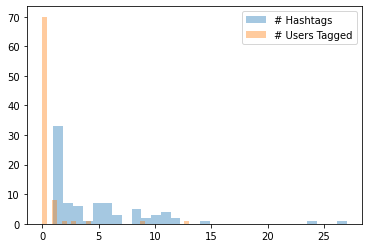

In [28]:
plt.hist(temp.hashtags_used, bins=30, alpha=.4, label='# Hashtags')#, density=True)
plt.hist(temp.users_tagged, bins=30, alpha=.4, label='# Users Tagged')#, density=True)

plt.legend()

In [21]:
temp

,username,id,retweet_from,template,retweet_id,text,date,retweets,favorites,adj_date,...,inferred_trending_start,hashtag,newly_exposed_users,pr,cc,outdeg,indeg,hashtags_used,users_tagged,includes_link
10202,astradiscover,1097122057329000448,,,,make this video most disliked video please --&...,2019-02-17 13:14:16,1,1,2019-02-17 18:44:16,...,2019-02-17 14:20:00,jharkhandwithmodi,5.0,0.000002,0.0,0.0,0.0,5,0,True
12553,nobeatinground1,1061579553435398144,,,,"#merapmmeraabhimaan ""india can’t work from the...",2018-11-11 11:21:03,0,1,2018-11-11 16:51:03,...,2018-11-11 11:05:00,merapmmeraabhimaan,2.0,0.000002,0.0,0.0,0.0,1,0,False
12554,nobeatinground1,1061581524653420544,,,,#merapmmeraabhimaan for the first time we have...,2018-11-11 11:28:53,0,0,2018-11-11 16:58:53,...,2018-11-11 11:05:00,merapmmeraabhimaan,2.0,0.000002,0.0,0.0,0.0,1,0,False
12555,nobeatinground1,1061583862730387459,,,,"#merapmmeraabhimaan ""imaandar kamdaar chowkida...",2018-11-11 11:38:10,0,1,2018-11-11 17:08:10,...,2018-11-11 11:05:00,merapmmeraabhimaan,2.0,0.000002,0.0,0.0,0.0,1,0,False
12556,nobeatinground1,1061584354852274178,,,,#merapmmeraabhimaan they abused mr modi from 2...,2018-11-11 11:40:08,0,2,2018-11-11 17:10:08,...,2018-11-11 11:05:00,merapmmeraabhimaan,2.0,0.000002,0.0,0.0,0.0,1,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1652,babypusarla,1104437442160013314,,,,#modifiedjobs #83worldcupontkss #cbnarmy #apwi...,2019-03-09 17:43:00,0,0,2019-03-09 23:13:00,...,2019-03-09 15:30:00,modifiedjobs,11.0,0.000002,0.0,0.0,0.0,6,0,True
1653,babypusarla,1104432422278508544,,,,#modifiedjobs #83worldcupontkss #cbnarmy #apwi...,2019-03-09 17:23:03,0,1,2019-03-09 22:53:03,...,2019-03-09 15:30:00,modifiedjobs,11.0,0.000002,0.0,0.0,0.0,6,0,True
1654,babypusarla,1104432605724729345,,,,#modifiedjobs #83worldcupontkss #cbnarmy #apwi...,2019-03-09 17:23:47,0,0,2019-03-09 22:53:47,...,2019-03-09 15:30:00,modifiedjobs,11.0,0.000002,0.0,0.0,0.0,6,0,True
1655,babypusarla,1104440461836447745,,,,#modifiedjobs #83worldcupontkss #cbnarmy #apwi...,2019-03-09 17:55:00,0,0,2019-03-09 23:25:00,...,2019-03-09 15:30:00,modifiedjobs,11.0,0.000002,0.0,0.0,0.0,6,0,True


In [15]:
print_tweets(zero_exposure_tweeters.query('outdeg == 0 and indeg == 0'))
             #.join(user_df, on='username', rsuffix='_userdf').sort_values('followers', ascending=False))

link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
hashtag abuser
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
hashtag abuser
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
hashtag abuser
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
link
hashtag abuser
link
link
link
link
link
link
master tagger
link
link
link
link
l

In [36]:
print_tweets(zero_exposure_tweeters.query('outdeg == 0 and indeg == 0').\
             join(user_df, on='username', rsuffix='_userdf').sort_values('followers', ascending=False))

https://t.co/bugpyahjqp #5aralıkdünyakadınhaklarıgünü #masterchefbr #felizmiércoles #wednesdaywisdom #goknightsgo #theflash #maari2trailer #uritrailer #urisurgicalstrike #म्हारा_वोट_भाजपा_को #gsat11
--lamb_ruthann, 208 followers, 1399 friends

very simple data entry job full bangla tutorial 2018 || data entry=========== https://t.co/uau73sugxu #5aralıkdünyakadınhaklarıgünü #masterchefbr #felizmiércoles #wednesdaywisdom #goknightsgo #theflash #maari2trailer #uritrailer #urisurgicalstrike #म्हारा_वोट_भाजपा_को #gsat11
--lamb_ruthann, 208 followers, 1399 friends

https://t.co/eptu6f7sim #5aralıkdünyakadınhaklarıgünü #masterchefbr #felizmiércoles #wednesdaywisdom #goknightsgo #theflash #maari2trailer #uritrailer #urisurgicalstrike #म्हारा_वोट_भाजपा_को #gsat11
--lamb_ruthann, 208 followers, 1399 friends

#5aralıkdünyakadınhaklarıgünü #masterchefbr #felizmiércoles #wednesdaywisdom #goknightsgo #theflash #maari2trailer #uritrailer #urisurgicalstrike #म्हारा_वोट_भाजपा_को #gsat11 https://t.co/mw

In [28]:
print_tweets(zero_exposure_tweeters.query('outdeg == 0 and indeg == 0'))

make this video most disliked video please --&gt;https://t.co/nzsdetcsda&lt;-- #pulwamaterrorattacks #successofmakeinindia #exposedeshdrohis #timeforrevenge geelani yasin malik abdul ghani bhat mirwaiz umar farooq #jharkhandwithmodi ck khanna
--astradiscover

#merapmmeraabhimaan "india can’t work from the centre, says raghuram rajan" "india works from every home, frm every kitchen, frm every field, frm every shed, frm every factory, frm every office, frm every school, frm every hospital, and we are all inspired by our pm."
--nobeatinground1

शरद यादव ने कल बोफ़ोर्स ग़लती से नहीं बल्कि जानबूझकर कहा था क्यूँकि बुड्ढा हमारे राहुल बाबा से जलता है ओर उनकी जगह मायावती को प्रधानमंत्री बनाना चाहता है 😂😂😂 #merapmmeraabhimaan #meraboothsabsemazboot #namoagain2019 #modi5yearchallenge
--memerhoonbsdk

#merapmmeraabhimaan for the first time we have a pm whose family has not made politics a business. every single member of his family is living an ordinary indian citizen's life. if india has to progr

In [32]:
zero_exposure_tweeters.join(user_df, on='username', rsuffix='_userdf')

,username,id,retweet_from,template,retweet_id,text,date,retweets,favorites,adj_date,...,id_userdf,location,description,followers,friends,statuses,type_userdf,new_description,temp,group
adj_date,,,,,,,,,,,,,,,,,,,,,
2019-02-17 17:39:00,sanjeevkr868,1097105854694752272,,,,pm मोदी ने रविवार को हजारीबाग में झारखंड को कई...,2019-02-17 12:09:00,0,0,2019-02-17 17:39:00,...,2441946972,,"समर शेष है, नही पाप का भागी केवल व्याध, जो त...",2442,3526,34652,4_other,"समर शेष है, नही पाप का भागी केवल व्याध, जो त...",समर शेष है नही पाप का भागी केवल व्याध जो तटस्...,1
2019-09-11 23:06:06,bjp4india,1171839848732340224,,,,प्रधानमंत्री श्री @narendramodi के 12 सितम्बर ...,2019-09-11 17:36:06,292,1594,2019-09-11 23:06:06,...,207809313,"6-a, deen dayal upadhyay marg,",official twitter account of the bharatiya jana...,12102221,3,193020,6_non-participant,None,non-participant,0
2019-09-12 14:13:38,bjp4india,1172068238961692672,,,,आज यहां आदिवासी बच्चों की शिक्षा और उनके कौशल ...,2019-09-12 08:43:38,133,487,2019-09-12 14:13:38,...,207809313,"6-a, deen dayal upadhyay marg,",official twitter account of the bharatiya jana...,12102221,3,193020,6_non-participant,None,non-participant,0
2019-09-12 15:13:56,bjp4india,1172083411713835008,,,,मैंने कहा था कि नई सरकार बनते ही पीएम किसान सम...,2019-09-12 09:43:56,550,3004,2019-09-12 15:13:56,...,207809313,"6-a, deen dayal upadhyay marg,",official twitter account of the bharatiya jana...,12102221,3,193020,6_non-participant,None,non-participant,0
2019-02-17 15:55:00,bjp4india,1097079676378312704,,,,3 वर्ष पहले झारखण्ड में केवल 3 मेडिकल कॉलेज थे...,2019-02-17 10:25:00,699,2102,2019-02-17 15:55:00,...,207809313,"6-a, deen dayal upadhyay marg,",official twitter account of the bharatiya jana...,12102221,3,193020,6_non-participant,None,non-participant,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-12 15:54:40,sourabhtamesh,1050693726907977729,,,,@rahulgandhi #gappupappu https://t.co/ximdwjkjzo,2018-10-12 10:24:40,0,0,2018-10-12 15:54:40,...,802408362239520768,ganj basoda,"विद्यार्थी, जिज्ञासु, आत्मविश्वासी, गर्वित भार...",119,150,1861,6_non-participant,None,non-participant,0
2018-10-17 18:44:43,aparichit70,1052548460736651264,,,,#gappupappu https://t.co/q9h58e3smq,2018-10-17 13:14:43,0,0,2018-10-17 18:44:43,...,1048465504967516160,"basoda, india","😃indian😃, fan apne @narendramodi ka",23,199,1182,6_non-participant,None,non-participant,0
2018-10-12 06:44:39,ljitu5183,1050555310841241600,,,,#navratri अवश्य जानिए कि दुर्गा जी सब बातों को...,2018-10-12 01:14:39,0,0,2018-10-12 06:44:39,...,NaN,NaN,NaN,NaN,NaN,NaN,6_non-participant,None,non-participant,0


## Process Tweet Text

In [112]:
import re
def process_text(text):
    # remove link
    text = re.sub(r'http\S+', '', text)
    
    # remove hashtags
    text = re.sub(r'#(\w+)', '', text)

    # remove tags
    text = re.sub(r'@(\w+)', '', text)

    if text.isspace():
        return 'empty string'
    return text

In [113]:
zero_exposure_tweeters.text.apply(process_text)

6308    pm modi lays foundation stone &amp; inaugurates development projects at hazaribagh.                                                                                                       
8326    झारखंड की  सरकार ने बहुत शानदार विधानसभा भवन बनवाए हैं.                                                                                                                                   
8699    empty string                                                                                                                                                                              
8949    grandma sells new born baby to save life of daughter in law. father of baby sick. mother of baby died at gumla                                                                            
9295     19 साल का इंतजार खत्म... finally, jharkhand has it's brand new vidhan sabha. prime minister shri  has inaugurated the new jharkhand vidhan sabha earlier today. this is remarkable  ji.  
                         

In [114]:
xs = [1, None, 2, 3, None, 5]

In [115]:
[x for x in xs if x is not None]

[1, 2, 3, 5]